In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import json
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

from src.datasets import MVTecAD, ImageNetTransforms
from src.mask import RandomMaskCollator
from src.util import show_tensor_image, pidx_to_imask, preds_to_image, visualize_on_masked_area
from src.models import mae_vit_base_patch16, mae_vit_large_patch16, mae_vit_huge_patch14

### Visualization with ImageNet-pretrained MAEs

In [3]:
data_root = "./data/mvtec_ad"
category = "bottle"
input_res = 224
split = "train"
custom_transforms = ImageNetTransforms(input_res)

dataset = MVTecAD(data_root, category, input_res, split, custom_transforms=custom_transforms)
len(dataset)

209

torch.Size([4, 3, 224, 224])
torch.Size([4, 147])
torch.Size([4, 1, 224, 224])


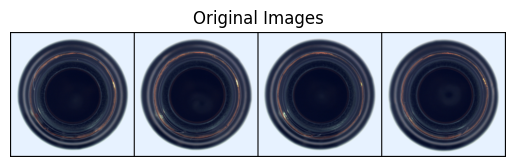

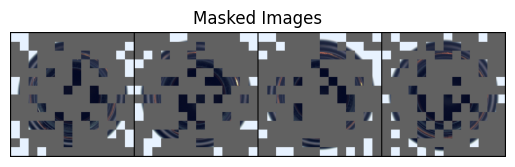

In [11]:
batch_size = 4
patch_size = 16
mask_ratio = 0.75
h, w = input_res//patch_size, input_res//patch_size
mask_collator = RandomMaskCollator(mask_ratio, input_res, patch_size)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=mask_collator)

batch = next(iter(data_loader))
org_batch, mask_batch = batch

images = org_batch["samples"]
images_mask = pidx_to_imask(mask_batch, h, w, patch_size)
masked_images = images * images_mask
print(images.shape)
print(mask_batch.shape)
print(images_mask.shape)

show_tensor_image(images, nrow=4, title="Original Images")
show_tensor_image(masked_images, nrow=4, title="Masked Images")

In [26]:
model = mae_vit_base_patch16()
ckpt_path = "./weights/mae_pretrain_vit_base_full.pth"
model.load_state_dict(torch.load(ckpt_path, weights_only=True)["model"])

<All keys matched successfully>

In [27]:
with torch.no_grad():
    model.eval()
    loss, pred = model(images, mask_batch)  # (B, 3, H, W)
print(loss, pred.shape)

tensor(2.7124) torch.Size([4, 3, 224, 224])


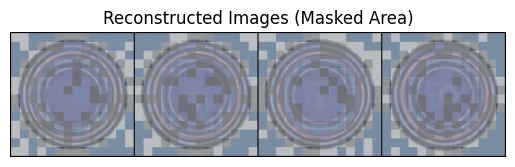

In [28]:
masked_imgs = visualize_on_masked_area(images, 1-images_mask, pred, patch_size, h, w)
show_tensor_image(masked_imgs, nrow=4, title="Reconstructed Images (Masked Area)")

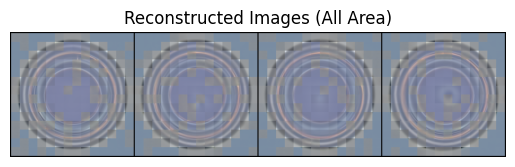

In [29]:
show_tensor_image(pred, nrow=4, title="Reconstructed Images (All Area)")

### Visualization with Fine-tuned MAEs

Loss : 0.014516896568238735


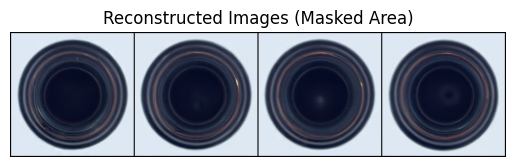

In [33]:
finetuned_weights = torch.load("weights/mae_finetune_vit_base_bottle_mvtec_ad.pth", weights_only=True)
finetuned_model = mae_vit_base_patch16()
finetuned_model.load_state_dict(finetuned_weights)

with torch.no_grad():
    finetuned_model.eval()
    loss, pred = finetuned_model(images, mask_batch)
    print(f"Loss : {loss}")

masked_imgs = visualize_on_masked_area(images, 1-images_mask, pred, patch_size, h, w)
show_tensor_image(masked_imgs, nrow=4, title="Reconstructed Images (Masked Area)")

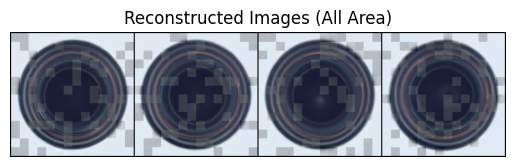

In [34]:
show_tensor_image(pred, nrow=4, title="Reconstructed Images (All Area)")